# Initialize notebook

In [1]:
import wandb

In [2]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import sample_batch, summary
from utils.train_utils.model_utils import Conv2dBlock, UpConv2dBlock

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


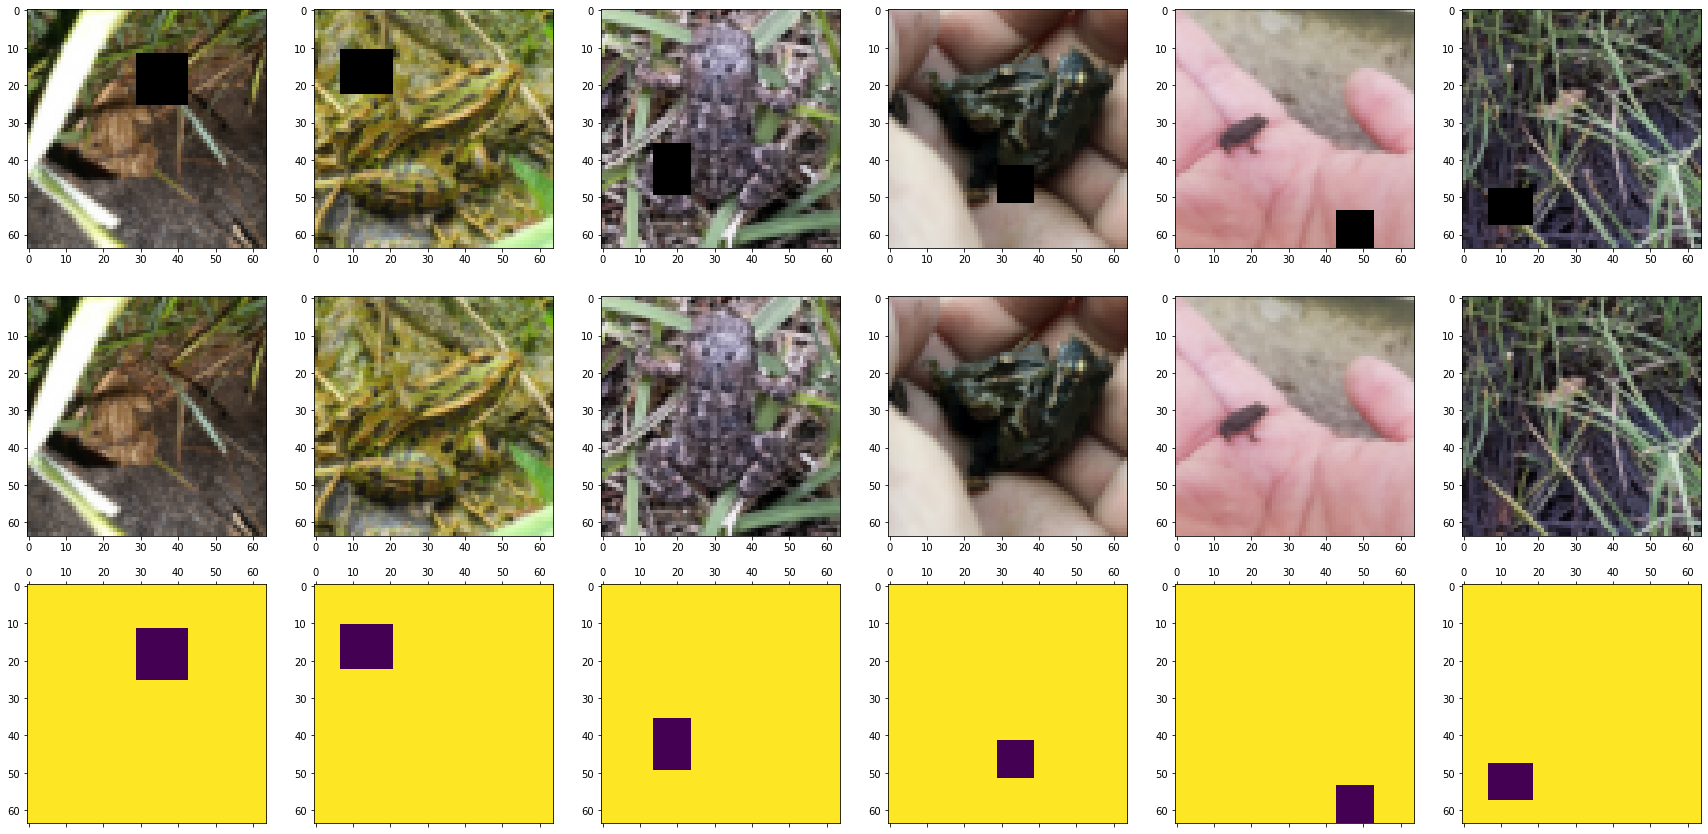

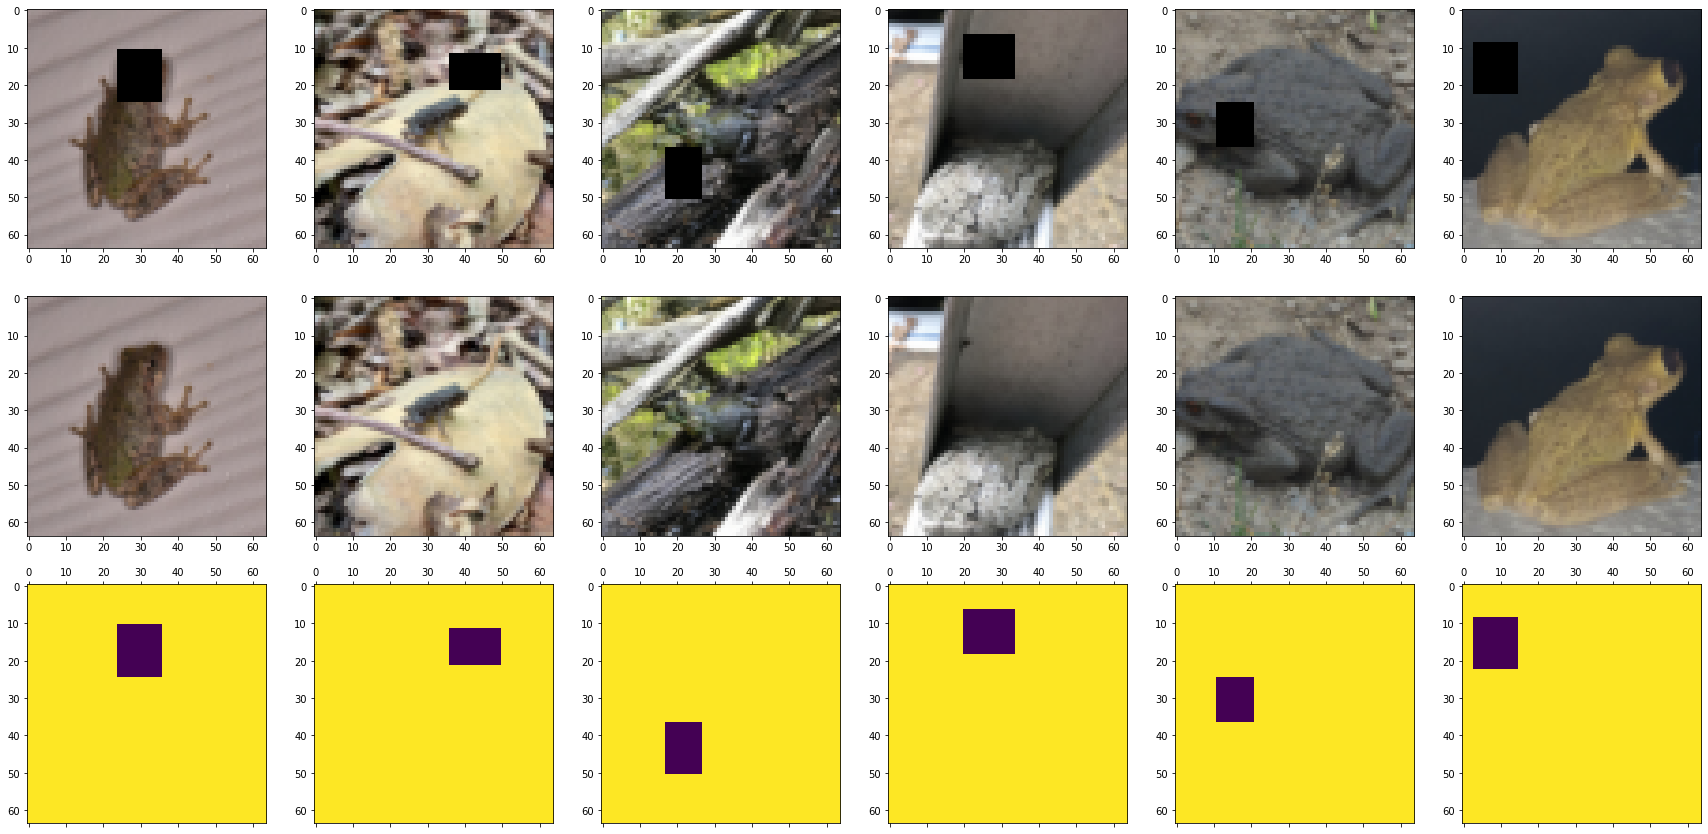

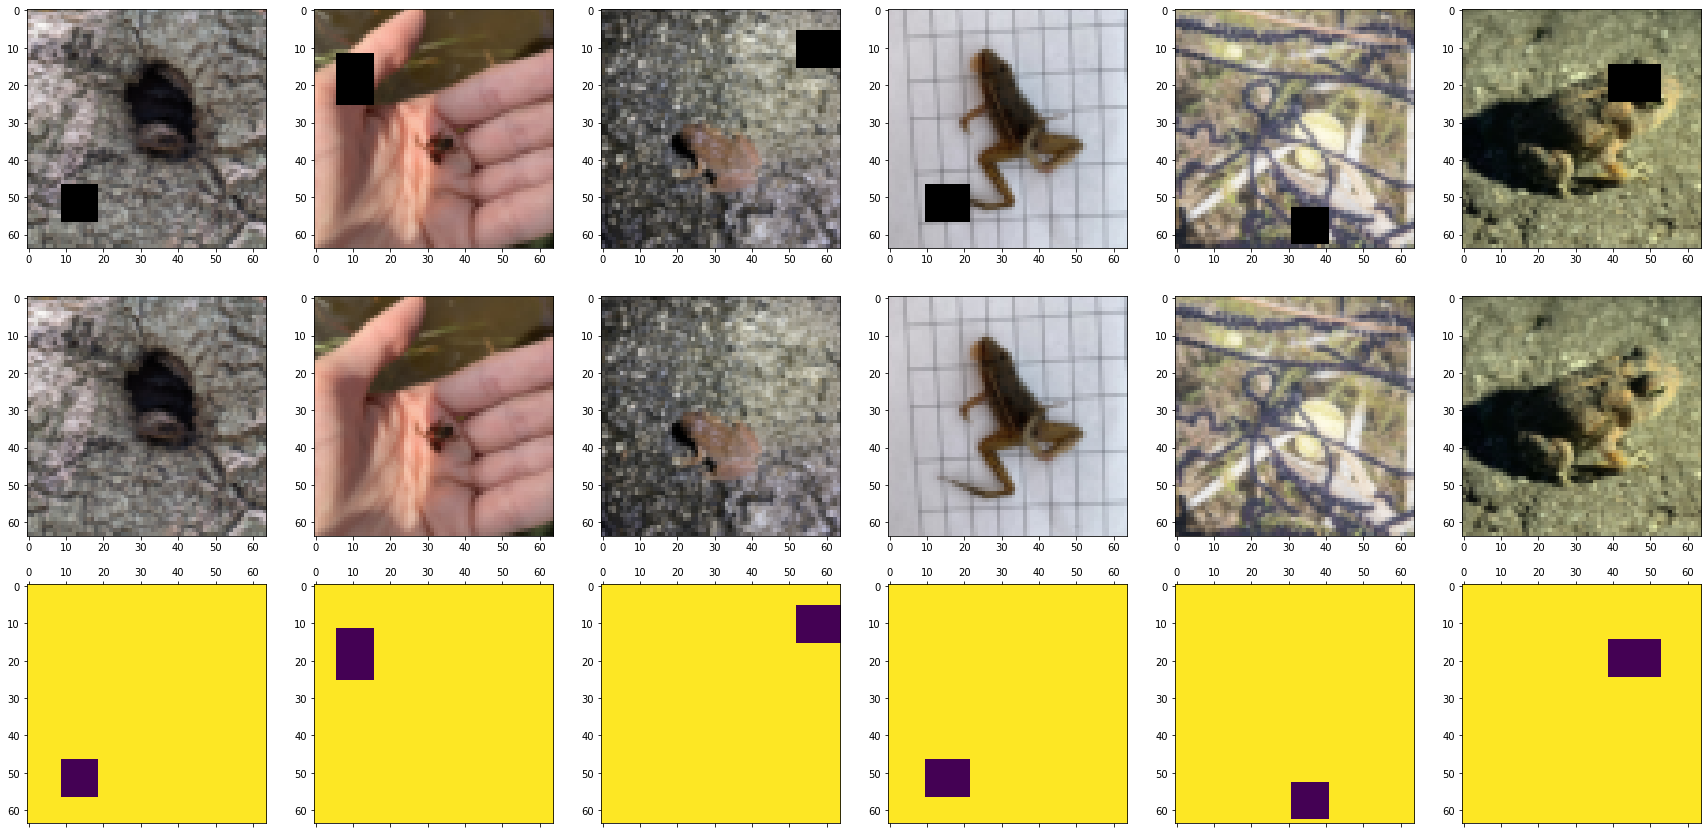

In [5]:
# sanity check 
sample_batch(train_dataset, sample_size = 6)
sample_batch(valid_dataset, sample_size = 6)
sample_batch(test_dataset, sample_size = 6)


# Introduction
This notebook aims to explore how the use of graphs to encode global information can improve capturing global context in image inpainting. The relevant references are:
1. How Powerful are Graph Neural Networks? (https://arxiv.org/abs/1810.00826)

# Model experiment


In [6]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(Generator, self).__init__()
        
        # same -> down -> same -> down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 8 x  same
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv5 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv6 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv7 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv8 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv9 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv10 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv11 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # upsample -> same -> upsample -> same
        self.conv12 = UpConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv13 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = UpConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv15 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')

    def forward(self, input_tensor):

        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # middle layers
        x = self.conv4(x) + x
        x = self.conv5(x) + x
        x = self.conv6(x) + x
        x = self.conv7(x) + x
        x = self.conv8(x) + x
        x = self.conv9(x) + x
        x = self.conv10(x) + x
        x = self.conv11(x) + x

        # up sample
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        x = self.final(x)

        return x


# Training configuration

In [7]:
MODEL_PARAMS = {
    "description" : """
        Base structure same as the GLCIC model, but with no dilated convolutions and with residual skips. 
        """,
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator" : "/home/e/e0425222/CS4243-project/active_experiments/Vanilla/AE/generator/generator",
}

TRAINING_PARAMS = {
    "num_epochs" : 20,
    "batch_size" : 64, 
    "learning_rate": 1e-3,
    "schedule_every" : 5,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [8]:
# 1. initialize model
generator = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"])

summary(generator)

# 2. device
parallel = True
device = 'cuda:1'  
devices = [1,0,2,3]

if not parallel:
    generator1 = generator.to(device)
else:
    generator1 = nn.DataParallel(generator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'none').sum()/(1-mask).sum()

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}

# 5. initialize optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator_model"] = generator
TRAINING_PARAMS["generator_optimizer"] = generator_optimizer
TRAINING_PARAMS["generator_scheduler"] = generator_scheduler
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function



model has 0.560067 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Initialize logging

In [9]:
wandb.init(project="Vanilla", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanyjnaaman (use `wandb login --relogin` to force relogin)


[]

# Train

## Train functions

In [10]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]

    # models
    generator = training_params["generator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_generator_r"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # set the gradients to zeros
            GENERATOR_OPTIMIZER.zero_grad()

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # ===== FORWARD PASS =====

            # 1. forward pass by generator to produce images, splice them
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 2. reconstruction loss
            loss_g_reconstruction = RECONSTRUCTION_LOSS(output_batched, ground_truth_batched, mask_batched)

            # 3. backprop
            loss_g = loss_g_reconstruction
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator_r"] += loss_g_reconstruction.detach().item()

            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
            

                # log images and some metadata
                wandb.log( {
                    "generator_train_images" : images,
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        
            # ===== HOUSEKEEPING =====
            del loss_g
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [11]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator = training_params["generator_model"].to(device).eval()

    # constants
    BATCH_SIZE = training_params["batch_size"]
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for _, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # get shuffled indices
            shuffled_indices = torch.randperm(n = BATCH_SIZE).long()

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, _ in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # log images and some metadata
                wandb.log( {
                    "generator_val_images" : images,
                })

                # log all metrics
                wandb.log(
                    {f"val_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [12]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_generator_r"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)

        print("Saved models!")

    return train_results, eval_results

## Train

In [13]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 0, log_wandb = True)


===== Epoch: 1 ===== 
155/156: Peak SnR (Whole): 30.52806480776879   L2 loss (Whole): 0.0015562863417735865   L2 loss (Mask): 0.13490271911986412   L1 loss (Whole): 0.004677977546628925   L1 loss (Mask): 0.4049131045418401   LPIPS (Whole): 0.04848662292765033   loss_generator_r: 0.13490271911986412      
15/15: Peak SnR (Whole): 31.92207209269206   L2 loss (Whole): 0.0006443016619111101   L2 loss (Mask): 0.05589474389950434   L1 loss (Whole): 0.003565973276272416   L1 loss (Mask): 0.3093990663687388   LPIPS (Whole): 0.03781787728269895       
Completed epoch 1! Took 1.1271203835805257 min
Saved models!

===== Epoch: 2 ===== 
155/156: Peak SnR (Whole): 31.879305931829638   L2 loss (Whole): 0.0006541651033330709   L2 loss (Mask): 0.05683804961942857   L1 loss (Whole): 0.003605474288304967   L1 loss (Mask): 0.3133116412547327   LPIPS (Whole): 0.038809414472310774   loss_generator_r: 0.05683804961942857     
15/15: Peak SnR (Whole): 32.42760022481283   L2 loss (Whole): 0.00057259128079749

({'Peak SnR (Whole)': [30.538066845673782,
   31.88346606034499,
   32.2586729098589,
   32.63776612893129,
   32.76038098946596,
   33.06445028843024,
   33.22158951637073,
   33.38635909251678,
   33.34622487043723,
   33.68174027173947,
   33.695424984662964,
   33.57334586901543,
   33.67704892769838,
   33.90157694694324,
   33.87330661675869,
   34.015503785549065,
   33.92137145996094,
   33.861008644104004,
   33.99926158709404,
   34.00544120103885],
  'L2 loss (Whole)': [0.0015502422419302047,
   0.0006535530852628513,
   0.0005981958454821068,
   0.0005470333109350087,
   0.000531794675528848,
   0.0004960768994164821,
   0.0004776649077076656,
   0.0004590349165552582,
   0.0004644783395447004,
   0.0004300505330693574,
   0.0004279859784172657,
   0.00044049645284525095,
   0.0004302164435592623,
   0.0004086046937094906,
   0.00041156075372456166,
   0.0003973867894204047,
   0.00040720895926008385,
   0.00041196238751767966,
   0.0003993322776902157,
   0.000398618418563

In [14]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 20, log_wandb = True)


===== Epoch: 21 ===== 
155/156: Peak SnR (Whole): 34.005314291677166   L2 loss (Whole): 0.0003985494185584567   L2 loss (Mask): 0.03463811075254794   L1 loss (Whole): 0.0026359725217785564   L1 loss (Mask): 0.22912857638251397   LPIPS (Whole): 0.0267695058978373   loss_generator_r: 0.03463811075254794   6   
15/15: Peak SnR (Whole): 33.92578913370768   L2 loss (Whole): 0.00040550280439977847   L2 loss (Mask): 0.035085710262258846   L1 loss (Whole): 0.0026396277515838545   L1 loss (Mask): 0.22827575206756592   LPIPS (Whole): 0.02627948150038719    
Completed epoch 21! Took 1.144655994574229 min
Saved models!

===== Epoch: 22 ===== 
155/156: Peak SnR (Whole): 34.05429928687311   L2 loss (Whole): 0.00039419155950928407   L2 loss (Mask): 0.034148660434349894   L1 loss (Whole): 0.002619051530716881   L1 loss (Mask): 0.22690407595326822   LPIPS (Whole): 0.02646844289716213   loss_generator_r: 0.034148660434349894     
15/15: Peak SnR (Whole): 34.08570353190104   L2 loss (Whole): 0.000391847

In [ ]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)